In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
directory = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("../input/face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("../input/face-mask-detection-dataset/submission.csv")

In [2]:
cvNet = cv2.dnn.readNetFromCaffe('../input/caffe-face-detector-opencv-pretrained-model/architecture.txt','../input/caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

In [3]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

In [4]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [5]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '3758.png',
 'NumOfAnno': 2,
 'Annotations': [{'isProtected': False,
   'ID': 217843115901993120,
   'BoundingBox': [112, 4, 455, 441],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 12530598208497002,
   'BoundingBox': [113, 237, 345, 440],
   'classname': 'mask_colorful',
   'Confidence': 1,
   'Attributes': {}}]}

In [6]:
#Data Visualization

In [7]:
df = pd.read_csv("../input/face-mask-detection-dataset/train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [8]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)    

In [9]:
len(data)

5749

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

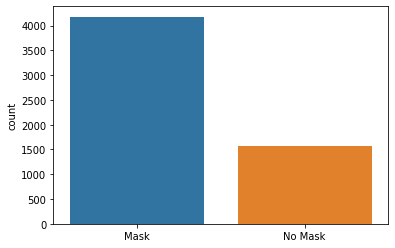

In [10]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [11]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)
X[0].shape

(124, 124, 3)

In [12]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)
np.unique(Y)

array([0, 1])

In [13]:
Y.shape

(5749,)

In [14]:
#Model Construction

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

2022-11-04 18:30:27.603214: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 128)     73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 460800)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 460800)            0

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [18]:
#Model Training

In [19]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [21]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-04 18:30:30.635499: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
143/143 [==============================] - 495s 3s/step - loss: 0.4381 - accuracy: 0.8091 - val_loss: 0.2445 - val_accuracy: 0.9104
Epoch 2/50
143/143 [==============================] - 505s 4s/step - loss: 0.3139 - accuracy: 0.8673 - val_loss: 0.2393 - val_accuracy: 0.8983
Epoch 3/50
143/143 [==============================] - 496s 3s/step - loss: 0.2799 - accuracy: 0.8853 - val_loss: 0.2092 - val_accuracy: 0.9017
Epoch 4/50
143/143 [==============================] - 493s 3s/step - loss: 0.2660 - accuracy: 0.8842 - val_loss: 0.1930 - val_accuracy: 0.9322
Epoch 5/50
143/143 [==============================] - 498s 3s/step - loss: 0.2611 - accuracy: 0.8894 - val_loss: 0.1914 - val_accuracy: 0.9278
Epoch 6/50
143/143 [==============================] - 502s 4s/step - loss: 0.2530 - accuracy: 0.8993 - val_loss: 0.2021 - val_accuracy: 0.9217
Epoch 7/50
143/143 [==============================] - 493s 3s/step - loss: 0.2404 - accuracy: 0.9015 - val_loss: 0.2174 - val_accuracy: 0.9165

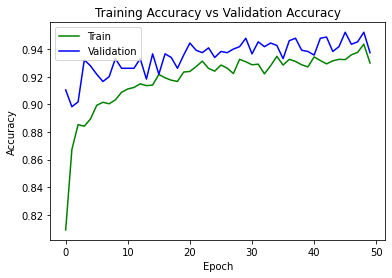

In [22]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

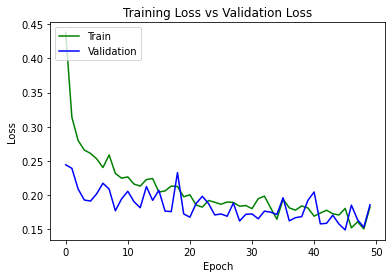

In [23]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
print(len(df_test["name"]),len(df_test["name"].unique()))

8142 1698


In [25]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']